# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откроем и изучим файл

Добавим pandas и необходимые модули из библиотеки sklearn.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/datasets/users_behavior.csv')
df.head(10)
#df.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Целевым признаком в нашей таблице является колонка с обозначением тарифа, которым клиент пользовался в течение месяца,  - "is_ultra" («Ультра» — 1, «Смарт» — 0).

Похожими по смыслу являются колонки "calls" и "minutes", целесообразно проверить их коррелируемость</div>

0.9820832355742293

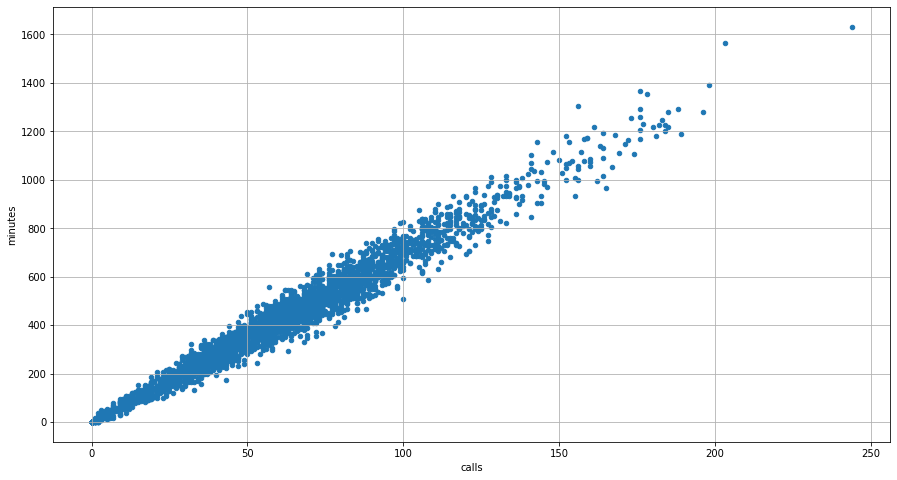

In [2]:
df.plot(x='calls', y='minutes', kind='scatter', figsize=(15, 8), sharex=False, grid=True)
df['calls'].corr(df['minutes'])

И по графику, и по значению коэффициента корреляции, близкому к 1 (0.98) видно, что признаки "calls" и "minutes" коллинеарны. Чтобы избавиться от мультиколлинарности, необходимо исключить из модели один из факторов, чтобы избавить модель от переобучаемости и увеличить время тренировки модели. Уберем из всех исследований признак "calls".


## Разбейте данные на выборки

Данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1. Применим к нашему датасету функцию train_test_split(), чтоб разделить его на тестовую выборку df_test (20%) и обучающую-вылидационную df_train_valid.

In [3]:
df_train_valid, df_test = train_test_split(df, test_size=0.2, random_state=12345)

Получившийся датасет df_train_valid разделим на валидационную (df_valid, 25%))  и обучающую выборки (df_train, 75%).

In [4]:
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=12345) 

## Исследуем модели

### Cоздадим переменные для признаков и целевого признака

In [5]:
features_train = df_train.drop(['is_ultra', 'calls'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra', 'calls'], axis=1)
target_valid = df_valid['is_ultra']

 ### Дерево решений
 Создадим цикл, который проверит качество модели для разных значений гиперпараметра решающего дерева — __max_depth__.

In [6]:
data_max_deph = pd.DataFrame(columns=['max_depth', 'accuracy'])
for depth in range(1, 10):
    model_1 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_1.fit(features_train, target_train)
    predictions_valid = model_1.predict(features_valid)
    data_max_deph = data_max_deph.append({'max_depth': depth, 
                       'accuracy': accuracy_score(target_valid, predictions_valid)},
                       ignore_index=True)
    
data_max_deph

,max_depth,accuracy
0,1.0,0.738725
1,2.0,0.757387
2,3.0,0.765163
3,4.0,0.765163
4,5.0,0.766719
5,6.0,0.766719
6,7.0,0.768274
7,8.0,0.763608
8,9.0,0.757387


Лучшее качество у модели с max_depth = 7

Значение Accuracy = 0,768.

### Cлучайный лес

Применим алгоритм классификации — случайный лес, с гиперпараметром __n_estimators__.

In [7]:
best_model = None
best_result = 0
for est in range(1, 11):
    model_2 = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model_2.fit(features_train, target_train) 
    result = model_2.score(features_valid, target_valid) 
    if result > best_result:
        best_model = model_2
        best_result = result
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Accuracy наилучшей модели на валидационной выборке: 0.7962674961119751


Лучшее значение Accuracy = 0,796.

### Логистическая регрессия

Обучим модель логистической регрессии на обучающей выборке.

In [8]:
model_3 = LogisticRegression(random_state=12345)
model_3.fit(features_train, target_train)
result_3 = model_3.score(features_valid, target_valid)
result_3

0.7013996889580093

Значение Accuracy при логистической регрессии всего 0,701.

### Лучшее значение Accuracy

Лучшее значение Accuracy у модели с алгоритмом классификации "случайный лес", худший результат у "логистической регрессии".

## Проверьте модель на тестовой выборке

Проверим вторую модель ("случайный лес") на тестовой выборке.

In [9]:
features_test = df_test.drop(['is_ultra', 'calls'], axis=1)
target_test = df_test['is_ultra']

In [10]:
best_model.score(features_test, target_test) 

0.7838258164852255

Качество модели на тестовой выборке 0.78, что удовоетворяет требования к проекту.

## (бонус) Проверьте модели на адекватность

Чтобы оценить адекватность модели, сравним ее качество с Dummy моделью.

In [16]:
from sklearn.dummy import DummyClassifier
strategies = ['most_frequent']

dummy_results = []
for strategy in strategies:
    dc = DummyClassifier(strategy = strategy, random_state = 42)
    dc.fit(features_train, target_train) 
    result = dc.score(features_test, target_test)
    dummy_results.append({strategy: result}) 
    pd.DataFrame(dummy_results)
dummy_results

[{'most_frequent': 0.6951788491446346}]

Качество полученных моделей выше, чем у Dummy модели с параметром "most_frequent".

## Вывод

В данном проекте исследовались разные модели, для определения наиболее подходящего тарифа (задача бинарной классификации) клиентам оператора мобильной связи «Мегалайн». 

Были рассмотрены 3 алгоритма классификации:
- Классификатор дерева решений (Decision Tree Classifier);
- Случайный Лес (Random Forest);
- Логистическая регрессия (Logistic Regression).

Самое лучшее значение Accuracy у модели с алгоритмом классификации "случайный лес":
- на тестовой выборке (20% от всего дататсета) - 0.78;
- на всем датасете - 0.895,
что является достаточно высоким показателем, чтоб применить данную модель для определения подходящего тарифа клиентам «Мегалайн».